# Heartbeat Classification

## Modeling

### Imports & Preprocessing

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from importlib import reload
from imblearn.metrics import classification_report_imbalanced
from scipy import signal
from sklearn.utils.class_weight import compute_class_weight

import modelling_utils as mutils
from Mlflow_report import Mlflow_report
from Networks import Networks

df = pd.read_pickle("../data/.MIT_Heartbeat_original_fs180hz.pkl")

# Infos
fs = 180
record_length = 315
df.head()

# Additional Information
class_labels = {"N": 0,
                "S": 1,
                "V": 2,
                "F": 3,
                "Q": 4}
labels_long = {0: "N: Normal beat",
               1: "S: Supraventricular premature beat",
               2: "V: Premature ventricular contraction",
               3: "F: Fusion of ventricular and normal beat",
               4: "Q: Unclassifiable beat"}

Additional Information (record, age, gender, medication, device) well be droped, as there are only 48 records. Therefore it would be possible to identify the patient only with these metadata. 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105416 entries, 0 to 105415
Columns: 636 entries, record to v5_314
dtypes: float64(630), object(6)
memory usage: 511.5+ MB


In [3]:
reload(mutils)

<module 'modelling_utils' from 'c:\\Users\\felix\\Documents\\jul24_bds_int_heartbeat\\notebooks\\modelling_utils.py'>

### Datapreprocessing - Functions

In [4]:
# Datapreprocessing
# 1. Remove Jumps at the start and end with a digital lowpass-filter
def digital_filter_preprocess(X):
    """
    Removing jumps at the start/end of the Signal with a digital lowpass-filter (Jumps have high-frequency-content)
    -> Doesn't work to well, because a lot of the signal is changed by decreasing the jumps with a lowpass-filter
    """
    b, a = signal.butter(2, 10, fs=180, btype='low', analog=False)
    w, h = signal.freqs(b, a)
    X2 = signal.filtfilt(b, a, np.array(X), axis=0)


    plt.figure(figsize=(12, 6))
    for i in np.random.randint(0, 100000, 2):
        plt.plot(np.arange(0, 315), np.array(X)[i,:].transpose())
        plt.xlim([50, 250])
        plt.plot(np.arange(0, 315), np.array(X2)[i,:].transpose(), '--')
    return X2


# Preprocessing
def substract_mean(X, n=3, plot=False):
    """ Mean-Substraction
    Idea: Take the first and last n values of the non-zero-signal, calculate the mean und substract that vom the signal.
    -> Is working ok. Could increase the accuracy
    """
    X2 = np.zeros_like(np.array(X))
    for idx, row in enumerate(np.array(X)):
        row_without0 = row[row!=0]
        mean = np.array((row_without0[:n], row_without0[-n:])).mean()
        row_without0 = row_without0 - mean
        row_with0 = np.zeros_like(row)
        row_with0[row!=0] = row_without0
        X2[idx, :] = row_with0

    if plot:
        plt.figure(figsize=(12, 6))
        for i in np.random.randint(0, 100000, 2):
            plt.plot(np.arange(0, 315), np.array(X)[i,:].transpose())
            plt.xlim([50, 250])
            plt.plot(np.arange(0, 315), np.array(X2)[i,:].transpose(), '--')
    return pd.DataFrame(X2, columns=X.columns)


# Delete some of the normal heartbeats
def delete_rows_of_class_n(X, y, p=0.5, label=0):
    """ Delete 'p' percent of the rows with 'label' """
    y_class = pd.DataFrame(y[y == label])
    idx_random = np.random.randint(0, np.size(y_class), np.int32(np.size(y_class)*p))
    idx_original = y_class.index[idx_random]

    y2 = y.drop(idx_original)
    X2 = X.drop(idx_original)
    return X2, y2


def preprocess_fft(X, fs=180, plot=False):
    n = np.shape(X)[1]
    n_2 = np.int32(np.ceil(n/2))

    # get window according to mean signal length (a little bit bigger (*1.2))
    window_length = np.int32((X == 0).sum().sum() / np.prod(X.shape) * n * 1.2)
    window = np.hanning(window_length)
    # Max position is always the same (see import)
    pos_max = np.argmax(X.iloc[23,:])
    # X_window = np.array(X)
    X_window = np.array(substract_mean(X, n=3))
    X_window[:, pos_max-np.int32(np.ceil(window_length/2)):pos_max+np.int32(np.floor(window_length/2))] = X_window[:, pos_max-np.int32(np.ceil(window_length/2)):
                                                                                                                    pos_max+np.int32(np.floor(window_length/2))] * window.T

    X_fft = np.fft.fft(X_window, axis=1)
    f = np.fft.fftfreq(n, 1/fs)[0:n_2]
    amplitude = np.abs(X_fft[:, 0:n_2])
    phase = np.unwrap(np.angle(X_fft))[:, :n_2] + f*400/90
    # phase = (np.angle(X_fft))
    phase = np.unwrap(phase)

    if plot:
        i = [20, 26, 3304, 23424]
        fig, ax = plt.subplots(2, 1, figsize=(12, 10))
        ax[0].plot(f, amplitude[i, :].T)
        ax[1].plot(f, phase[i, :].T, 'x-')

    X_new = X_new = np.concatenate((amplitude, phase), axis=1)[:, 0:n]
    return pd.DataFrame(X_new)



In [5]:
# Seperate L2 and v5 electrode and class
X_l2 = df.iloc[:, 6:6+record_length]
X_v5 = df.iloc[:, 6+record_length:]
X_l2v5 = df.iloc[:, 6:]
X = X_l2
y = df["class"].replace(class_labels)

# X = digital_filter_preprocess(X)
# X = substract_mean(X, n=3)
# X, y = delete_rows_of_class_n(X, y, p=0.5, label=0)
#X = preprocess_fft(X)

X_train_l2, X_test_l2, y_train_labels, y_test_labels = train_test_split(X_l2, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
X_train_v5, X_test_v5, y_train_labels, y_test_labels = train_test_split(X_v5, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
X_train_l2v5, X_test_l2v5, y_train_labels, y_test_labels = train_test_split(X_l2v5, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# One-Hot-Encoding
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

C:\Users\felix\AppData\Local\Temp\ipykernel_15792\186622587.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df["class"].replace(class_labels)


{0: 0.23988963006158529,
 1: 7.638768115942029,
 2: 3.4197891321978915,
 3: 29.694366197183097,
 4: 2.670847189231987}

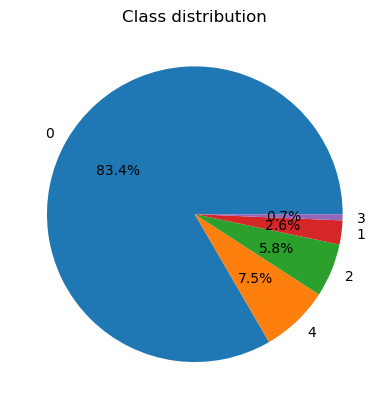

In [6]:
plt.pie(y.value_counts(), labels=y.value_counts().index, autopct='%.1f%%')
plt.title("Class distribution")

# Initialize class weights according to the amount of data:
# (Multiplication to "normalize" the weights)
class_weights = dict(1/y.value_counts() * y.value_counts().max())
# class_weights[3] = class_weights[3]/2


class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
class_weights

weights = y.value_counts()
weights
class_weights

In [7]:

import Mlflow_report as report
from importlib import reload

reload(report)
logger = report.Mlflow_report()
print(logger.report_autolog(disable=False))
logger.start_server()

# -----------------------------------------------
# anaconda-prompt:
# activate Heartbeat (<- Python environment)
# cd Documents\jul24_bds_int_heartbeat\notebooks
# mlflow server --host 0.0.0.0 --port 8080
# -----------------------------------------------

2024/10/22 10:40:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/22 10:40:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/10/22 10:40:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


None
starting server not possible from Class.
Use: !mlflow server --host 0.0.0.0 --port 8080 in notebook und interrupt it!
Adress: http://127.0.0.1:8080


In [8]:

logger.set_tracking_uri()

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
# SHOULD WORK WITH EVERY MODEL
def sigmoid_weights(weights):
    """ Custom modification of the sigmoid function to have a little bit of different values"""
    weights = np.array(list(class_weights.values()))
    weights = weights / np.min(weights)
    weights =  1/(1+np.exp(-(weights/10-0.9)))
    weights_dict = {i: weights[i] for i in range(len(weights))}
    return weights_dict

weights1 = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
weights2 = class_weights
weights3 = sigmoid_weights(class_weights)


# Strings must match the class methods of Networks
model_names = ("model_combined_cnn_1",
               )
network = Networks()


kernel_sizes = [5] # [None, 3, 5, 7]
weights = [weights3] # [weights1, weights2, weights3]
weight_names = ["sigmoid_weights"] # ["no_weights", "balanced_weights", "sigmoid_weights"]
datas = ["L2_and_V5"] # L2: Only L2 / V5: only V5 / L2_and_V5: L2 and V5 treated sepreatly / L2V5: L2+V5 added after each other
preprocesses = ["Nothing"] # If any kind of preprocessing is done
domains = ["Time"] # Time / Freq domain
batch_sizes =  [256, 512, 1024, 2048] # [256, 512, 1024, 2048, 4096]
data_train = [[X_train_l2, X_train_v5]]
data_test = [[X_test_l2, X_test_v5]]

show_log = 0

logger.report_autolog(disable=False)
i = 0
for weight, weight_name in zip(weights, weight_names):
    for X_train, X_test, data_name, preprocess, domain in zip(data_train, data_test,
                                                         datas, preprocesses, domains):
        for model_name in model_names:
            for kernel_size in kernel_sizes:
                for batch_size in batch_sizes:

                    if "combined" in model_name and len(X_train) != 2:
                    # Combined model needs the L2_and_V5 dataset (shape of Dataset: (2, rows, 315))
                        i += 1
                        continue # skip loop-iteration
                    elif "combined" not in model_name and len(X_train) == 2:
                        i += 1
                        continue # skip loop iteration if dataset L2_and_V5 not combined with a "combined"-net

                    # This should make sure, that a new model is generated for each batch size
                    if "cnn" in model_name and kernel_size is not None:
                        function = getattr(network, model_name)
                        model = function(input=np.shape(X_train)[-1], kernel_size=kernel_size)
                    elif "cnn" in model_name and kernel_size is None:
                        i += 1
                        continue # skip loop for cnn, if there is no kernel-size
                    elif "cnn" not in model_name and kernel_size is not None:
                        i += 1
                        continue # skip loop iteration, for models without a kernel_size input
                    else:
                        function = getattr(network, model_name)
                        model = function(input=np.shape(X_train)[-1])


                    if len(X_train) == 2:
                        # Combined Net
                        X_train = (np.array(X_train[0]), np.array(X_train[1]))
                        X_test = (np.array(X_test[0]), np.array(X_test[1]))
                    else:
                        X_train = np.array(X_train)
                        X_test = np.array(X_test)
                    history = model.fit(X_train, np.array(y_train),
                            batch_size=batch_size, epochs=125, validation_split=0.25, class_weight=weight, verbose=show_log)
                    y_pred_train = model.predict(X_train, verbose=show_log).argmax(axis=1)
                    y_pred_test = model.predict(X_test, verbose=show_log).argmax(axis=1)
                    # Generate Report
                    logger.rename(f"{model.name}_{data_name}_{domain}_{preprocess}_{weight_name}_bs_{batch_size}_k{kernel_size}")
                    report = logger.performancesummary(y_train_labels, y_pred_train, y_test_labels, y_pred_test)

                    # # Generate training history
                    fig = mutils.plot_metrics_from_history_express(history, f"Training History {model.name} {data_name} {domain} {weight_name} k{kernel_size} - batch_size={batch_size}", show=False)
                    logger.log_history_figure(fig=fig, name=f"Training_History_{model.name}_{data_name}_{domain}_{preprocess}_bs_{batch_size}_{weight_name}_k{kernel_size}.html")
                    logger.add_param({"Domain": domain,
                                      "Preprocess": preprocess,
                                      "Data": data_name,
                                      "Model": model.name,
                                      "Weights": weight_name,
                                      "Kernel_size": kernel_size,
                                      })
                    logger.end_run()

                    # Display Progress:
                    i += 1
                    print(f"{'-'*50} \n{'-'*20}   {i}/{(len(datas)*len(model_names)*len(batch_sizes)*len(weight_names))}   {'-'*20} \n{'-'*50}")


2024/10/04 18:30:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/10/04 18:30:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/10/04 18:30:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/04 18:30:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e35a279ef3e5460eac1214c28a913106', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


2024/10/04 18:36:49 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'tuple'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2024/10/04 18:36:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\felix\AppData\Local\Temp\tmptys6z27k\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\felix\AppData\Local\Temp\tmptys6z27k\model\data\model\assets
2024/10/04 18:36:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\felix\AppData\Local\Temp\tmptys6z27k\model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.1']. Set logging level to DEBUG to see the full traceback. 
2024/10/04 18:36:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/04 18:36:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run exultant-skunk-480 at: http://localhost:8080/#/experiments/0/runs/e35a279ef3e5460eac1214c28a913106.
2024/10/04 18:36:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.
2024/10/04 18:37:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run Combined_cn

-------------------------------------------------- 
--------------------   1/4   -------------------- 
--------------------------------------------------


2024/10/04 18:37:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2c9b11836c8e43998790393a9f12f6bc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


2024/10/04 18:42:38 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'tuple'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2024/10/04 18:42:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\felix\AppData\Local\Temp\tmpkgp8nr4z\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\felix\AppData\Local\Temp\tmpkgp8nr4z\model\data\model\assets
2024/10/04 18:42:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\felix\AppData\Local\Temp\tmpkgp8nr4z\model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.1']. Set logging level to DEBUG to see the full traceback. 
2024/10/04 18:42:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/04 18:42:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-shrimp-870 at: http://localhost:8080/#/experiments/0/runs/2c9b11836c8e43998790393a9f12f6bc.
2024/10/04 18:42:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.
2024/10/04 18:43:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run Combined_cnn_

-------------------------------------------------- 
--------------------   2/4   -------------------- 
--------------------------------------------------


2024/10/04 18:43:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8e411242d2d44f64a75eba50a39cf4fa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


2024/10/04 18:48:32 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'tuple'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2024/10/04 18:48:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\felix\AppData\Local\Temp\tmprwn6ekqw\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\felix\AppData\Local\Temp\tmprwn6ekqw\model\data\model\assets
2024/10/04 18:48:40 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\felix\AppData\Local\Temp\tmprwn6ekqw\model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.1']. Set logging level to DEBUG to see the full traceback. 
2024/10/04 18:48:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/04 18:48:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-perch-60 at: http://localhost:8080/#/experiments/0/runs/8e411242d2d44f64a75eba50a39cf4fa.
2024/10/04 18:48:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.
2024/10/04 18:49:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run Combined_cn

-------------------------------------------------- 
--------------------   3/4   -------------------- 
--------------------------------------------------


2024/10/04 18:49:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9ace6cfca9b843ad96db515cc80143c1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


2024/10/04 18:54:25 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'tuple'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2024/10/04 18:54:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\felix\AppData\Local\Temp\tmpham8sa7i\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\felix\AppData\Local\Temp\tmpham8sa7i\model\data\model\assets
2024/10/04 18:54:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\felix\AppData\Local\Temp\tmpham8sa7i\model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.1']. Set logging level to DEBUG to see the full traceback. 
2024/10/04 18:54:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/04 18:54:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run intelligent-koi-294 at: http://localhost:8080/#/experiments/0/runs/9ace6cfca9b843ad96db515cc80143c1.
2024/10/04 18:54:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.
2024/10/04 18:54:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run Combined_c

-------------------------------------------------- 
--------------------   4/4   -------------------- 
--------------------------------------------------


In [ ]:
# DOES THE REST OF THE LOOPS
# SHOULD WORK WITH EVERY MODEL
def sigmoid_weights(weights):
    """ Custom modification of the sigmoid function to have a little bit of different values"""
    weights = np.array(list(class_weights.values()))
    weights = weights / np.min(weights)
    weights =  1/(1+np.exp(-(weights/10-0.9)))
    weights_dict = {i: weights[i] for i in range(len(weights))}
    return weights_dict

weights1 = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}
weights2 = class_weights
weights3 = sigmoid_weights(class_weights)


# Strings must match the class methods of Networks
model_names = (
            #    "model_dense1",
            #    "model_dense2",
            #    "model_convolution_smallkernel",
            #    "model_convolution_bigkernel",
            #    "model_combined_dense_1",
               "model_combined_dense_2",
               )
network = Networks()



weights = [weights1, weights2, weights3]
weight_names = ["no_weights", "balanced_weights", "sigmoid_weights"]
datas = ["L2_and_V5"] # L2: Only L2 / V5: only V5 / L2_and_V5: L2 and V5 treated sepreatly / L2V5: L2+V5 added after each other
preprocesses = ["Nothing"] # If any kind of preprocessing is done
domains = ["Time"] # Time / Freq domain
batch_sizes =  [256, 512, 1024, 2048, 4096]
data_train = [[X_train_l2, X_train_v5]]
data_test = [[X_test_l2, X_test_v5]]

show_log = 0

logger.report_autolog(disable=False)
i = 0
for weight, weight_name in zip(weights, weight_names):
    for X_train, X_test, data_name, preprocess, domain in zip(data_train, data_test,
                                                         datas, preprocesses, domains):
        for model_name in model_names:
            for batch_size in batch_sizes:

                if "combined" in model_name and len(X_train) != 2:
                # Combined model needs the L2_and_V5 dataset (shape of Dataset: (2, rows, 315))
                    i += 1
                    continue # skip loop-iteration
                elif "combined" not in model_name and len(X_train) == 2:
                    i += 1
                    continue # skip loop iteration if dataset L2_and_V5 not combined with a "combined"-net

                # This should make sure, that a new model is generated for each batch size
                function = getattr(network, model_name)
                model = function(input=np.shape(X_train)[-1])

                if len(X_train) == 2:
                    # Combined Net
                    X_train = (np.array(X_train[0]), np.array(X_train[1]))
                    X_test = (np.array(X_test[0]), np.array(X_test[1]))
                else:
                    X_train = np.array(X_train)
                    X_test = np.array(X_test)
                history = model.fit(X_train, np.array(y_train),
                        batch_size=batch_size, epochs=30, validation_split=0.25, class_weight=weight, verbose=show_log)
                y_pred_train = model.predict(X_train, verbose=show_log).argmax(axis=1)
                y_pred_test = model.predict(X_test, verbose=show_log).argmax(axis=1)
                # Generate Report
                logger.rename(f"{model.name}_{data_name}_{domain}_{preprocess}_{weight_name}_bs_{batch_size}")
                report = logger.performancesummary(y_train_labels, y_pred_train, y_test_labels, y_pred_test)

                # Generate training history
                fig = mutils.plot_metrics_from_history_express(history, f"Training History {model.name} {data_name} {domain} {weight_name} - batch_size={batch_size}", show=False)
                logger.log_history_figure(fig=fig, name=f"Training_History_{model.name}_{data_name}_{domain}_{preprocess}_bs_{batch_size}_{weight_name}.html")
                logger.add_param({"Domain": domain,
                                  "Preprocess": preprocess,
                                  "Data": data_name,
                                  "Model": model.name,
                                  "Weights": weight_name,
                                  })
                logger.end_run()

                # Display Progress:
                i += 1
                print(f"{'-'*50} \n{'-'*20}   {i}/{(len(datas)*len(model_names)*len(batch_sizes)*len(weight_names))}   {'-'*20} \n{'-'*50}")


In [13]:
# Single training:

# Strings must match the class methods of Networks
model_name = "model_combined_cnn_1"
network = Networks()
kernel_size = 5

datas = ["L2_and_V5"] # L2: Only L2 / V5: only V5 / L2_and_V5: L2 and V5 treated sepreatly / L2V5: L2+V5 added after each other
batch_size =  256
X_train = [X_train_l2, X_train_v5]
X_test = [X_test_l2, X_test_v5]
weight = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}


function = getattr(network, model_name)
model = function(input=np.shape(X_train)[-1], kernel_size=kernel_size)

if len(X_train) == 2:
    # Combined Net
    X_train = (np.array(X_train[0]), np.array(X_train[1]))
    X_test = (np.array(X_test[0]), np.array(X_test[1]))
else:
    X_train = np.array(X_train)
    X_test = np.array(X_test)

history = model.fit(X_train, np.array(y_train),
                    batch_size=batch_size, epochs=125, validation_split=0.25, class_weight=weight)
y_pred_train = model.predict(X_train).argmax(axis=1)
y_pred_test = model.predict(X_test).argmax(axis=1)
# Generate Report
report = mutils.print_crosstab(y_train_labels, y_pred_train, y_test_labels, y_pred_test, normalize=False)

# Generate training history
fig = mutils.plot_metrics_from_history_express(history, f"Training History", show=True)


2024/10/22 10:45:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '84c865e2aa7748809d68cc5020ba2018', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/125
248/248 [==============================] - 6s 16ms/step - loss: 0.6955 - Cat_accuracy: 0.8621 - F1_score_class0: 0.8369 - F1_score_class1: 0.0000e+00 - F1_score_class2: 0.0630 - F1_score_class3: 0.0000e+00 - F1_score_class4: 0.5140 - Precision_class0: 0.8737 - Precision_class1: 0.0000e+00 - Precision_class2: 0.9380 - Precision_class3: 0.0000e+00 - Precision_class4: 0.9212 - Recall_class0: 0.8031 - Recall_class1: 0.0000e+00 - Recall_class2: 0.0326 - Recall_class3: 0.0000e+00 - Recall_class4: 0.3565 - val_loss: 0.2986 - val_Cat_accuracy: 0.9249 - val_F1_score_class0: 0.9605 - val_F1_score_class1: 0.0000e+00 - val_F1_score_class2: 0.5631 - val_F1_score_class3: 0.0000e+00 - val_F1_score_class4: 0.9140 - val_Precision_class0: 0.9307 - val_Precision_class1: 0.0000e+00 - val_Precision_class2: 0.9218 - val_Precision_class3: 0.0000e+00 - val_Precision_class4: 0.9464 - val_Recall_class0: 0.9923 - val_Recall_class1: 0.0000e+00 - val_Recall_class2: 0.4054 - val_Recall_class3: 0.0000e+0

2024/10/22 10:52:05 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'tuple'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2024/10/22 10:52:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\felix\AppData\Local\Temp\tmpabqo5a9u\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\felix\AppData\Local\Temp\tmpabqo5a9u\model\data\model\assets
2024/10/22 10:52:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\felix\AppData\Local\Temp\tmpabqo5a9u\model, flavor: tensorflow). Fall back to return ['tensorflow==2.10.1']. Set logging level to DEBUG to see the full traceback. 
2024/10/22 10:52:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/22 10:52:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-fawn-771 at: http://localhost:8080/#/experiments/0/runs/84c865e2aa7748809d68cc5020ba2018.
2024/10/22 10:52:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/0.


659/659 [==============================] - 1s 2ms/step


In [14]:
if False:
    model.save("..\\models\\combined_cnn1_bs256_k5_noweights")

INFO:tensorflow:Assets written to: ..\models\combined_cnn1_bs256_k5_noweights\assets


INFO:tensorflow:Assets written to: ..\models\combined_cnn1_bs256_k5_noweights\assets


In [24]:
X_test[0].shape

(21084, 315)

# Lessons learned:
1. If handling the unbalenced classes with class-weights, the batch-size should be pretty high. The sum of all class-weights is ~ 182, it therefore needs a patch-size of 182 to have at 1 Class-3 sample (as it's random the batch-size should be much higher). It has show
2. Balanced-class weights are not the best. It actually learn better with even class weights (and even better with some nonelinear class weights (sigmoid-scaled)
)

# Questions

2. Learning-Rate:
     - is good at about 0.0001
     
     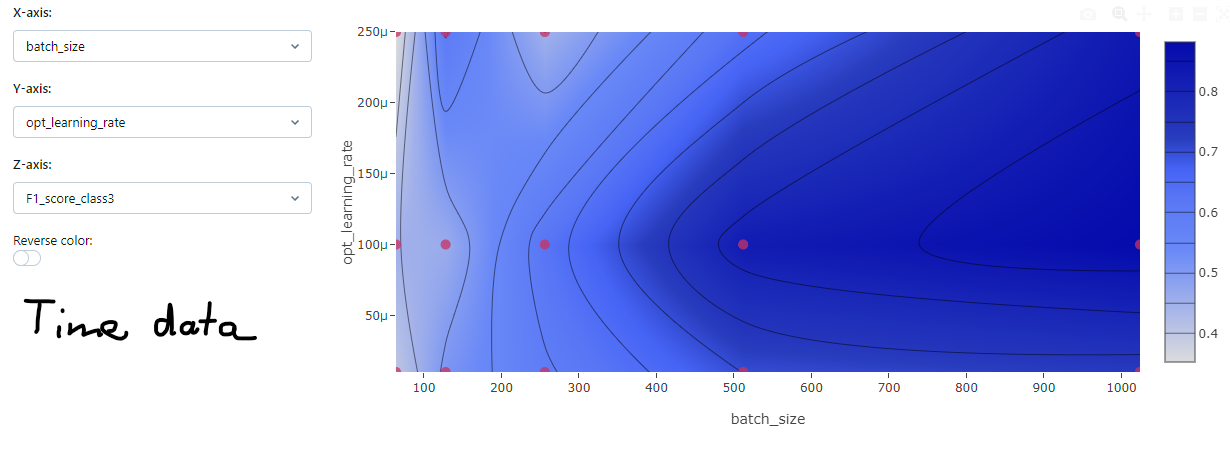